## Sandwich_profiles_from_xarray

This notebook explores processing profiles.

This is material copied from the end of Sandwich_analyze_ROI. These are experiments in processing transects, but don't run yet...they need the packages and data.

In [2]:
import numpy as np
import  json
from  shapely.geometry  import Polygon, Point
import shapely.ops as shops
#from descartes.patch import PolygonPatch
import shapely.vectorized
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
#import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
from scipy import interpolate, signal, stats
#from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

In [3]:
da = xr.open_dataarray('one_meter_test.nc')
(num_maps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',num_maps,xsize,ysize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Cross-shore'].values, da.coords['Alongshore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (1300, 280) (1300, 280)


In [8]:
def hmetrics( z, dx=1., dy=1.):
    """
    Calculate horizontal metrics in DEM coordiante
    My DEMs arrays need to be flipud'd on input to get north/south aspect correct.
    
    Peckham, S.D., 'Profile, Plan and Streamline Curvature: A Simple Derivation and Applications'
    Geomorphometery.org/2011.
    https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=8&cad=rja&uact=8&ved=2ahUKEwinl86vkKDgAhVQxVkKHaEVBlMQFjAHegQIARAC&url=https%3A%2F%2Fwww.geomorphometry.org%2Fsystem%2Ffiles%2FPeckham2011ageomorphometry.pdf&usg=AOvVaw1iq3Zz0N3fHhBDgi_jXD-R
    TODO: Check varying dx and dy. I think that is as simple as multipying the
          returned gradients by dx and dy.
    """
    fy, fx = np.gradient( z )
    fy = fy*dy
    fx = fx*dx
    
    slope = np.sqrt(fx**2 + fy**2)
    #  slope = np.pi/2. - np.arctan(slope_mag) # angle in radians
    aspect = np.rad2deg( np.arctan2(-fx, fy) )
    
    fxy, fxx = np.gradient(fx)
    fyy, fyx = np.gradient(fy)
    fxy = fxy*dy
    fxx = fxx*dx
    fyy = fyy*dy
    fyx = fyx*dx
    
    # profile curvature
    kp = (fx**2.*fxx + 2.*fx*fy*fxy + fy**2*fyy)/(-slope**2)
    # plan curvature
    kc = (fy**2.*fxx - 2.*fx*fy*fxy + fx**2*fyy)/(-slope**3)
    
    return slope, aspect, kp, kc

C:\Users\csherwood\AppData\Local\Continuum\anaconda3\envs\IOOS\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
C:\Users\csherwood\AppData\Local\Continuum\anaconda3\envs\IOOS\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'PiYG' is not defined

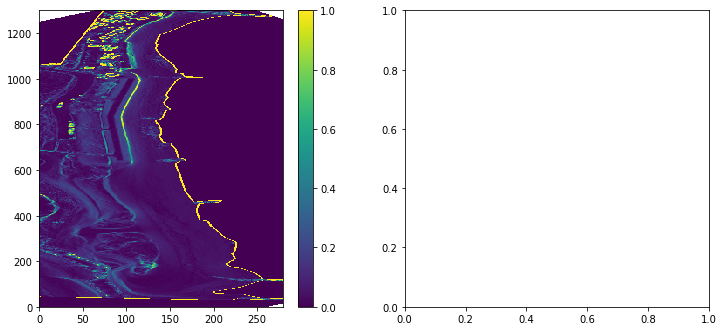

In [11]:
k = 1 # pick one of the maps
z = da[k,:,:].values

slope, aspect, kp, kc = hmetrics( z )

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
plt.pcolormesh(X,Y,slope,vmin=0,vmax=1.)
plt.colorbar()
ax = fig.add_subplot(222)
plt.pcolormesh(X,Y,aspect,vmin=-180.,vmax=180.,colormap=PiYG)
plt.colorbar()
ax = fig.add_subplot(223)
plt.pcolormesh(X,Y,kp,vmin=-.5,vmax=+.5)
ax = fig.add_subplot(224)
plt.pcolormesh(X,Y,kc,vmin=-.5,vmax=+.5)
plt.colorbar();

In [4]:
def pmetrics(x, y, z, MWL, MHW, dx=1.):
    """
    Find points on beach profile
    Assumes x starts somewhere offshore and is positive landward
    """
    # dict to hold result
    m = {}
    
    # hand-crafted max. beach widths
    bwmx = 100.
    if(y>600. and y<=1000.):
        bwmx = 50.
    if(y>1000):
        bwmx = 20.
    
    # smoothed profile
    #  size of Gauss kernal (meters)
    gkn = int(3/dx)
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    zf = convolve(np.array(z), gauss_kernel)
    
    # derivatives of unsmoothed profile
    zip = np.array((0))
    dz =  np.diff( np.append(zip, z) )
    ddz = np.diff( np.append(zip, dz) )
    
    # derivative of smoothed profile
    dzf = np.diff( np.append(zip, zf))

    # eliminate big jumps
    dz[np.abs(ddz)>20.]=np.NaN
    ddz[np.abs(ddz)>20.]=np.NaN
    dzf[np.abs(dzf)>20.]=np.NaN
    
    # find highest point on profile: phi
    # max of z
    iphi = np.nanargmax(z)
    m['phi'] = z[iphi]
    m['xphi'] = x[iphi]
    
    # if this is >MWL, then also call it dhi
    m['dhi'] = np.NaN
    m['xdhi'] = np.NaN
    if(m['phi']>MWL):
        m['dhi'] = z[iphi]
        m['xdhi'] = x[iphi]

    # find MWL by fitting line to nearby points
    try:
        idx = np.argwhere(np.logical_and(np.abs(zf-MWL)<0.3, x<175))
        slope, intercept, r_value, p_value, stderr = \
           stats.linregress( np.squeeze(x[idx]),np.squeeze(z[idx]) )
        print("slope, intercept, r:",slope, intercept, r_value)
        xMWL = (MWL-intercept)/slope
        iMWL = np.argwhere(x<=xMWL)[-1]
        plt.plot(x[idx],z[idx],'.b')
        plt.plot(x[idx],x[idx]*slope+intercept,'-r')
        m['xMWL']=xMWL
    except:
        m['xMWL']=np.NaN
  
    # find MHW by fitting line to nearby points
    try:
        idx = np.argwhere(np.logical_and(np.abs(zf-MHW)<0.3, x<175))
        slope, intercept, r_value, p_value, stderr = \
           stats.linregress( np.squeeze(x[idx]),np.squeeze(z[idx]) )
        print("slope, intercept, r:",slope, intercept, r_value)
        xMHW = (MHW-intercept)/slope
        iMHW = np.asscalar(np.argwhere(x<=xMHW)[-1])
        m['xMHW']=xMHW

        plt.plot(x[idx],z[idx],'.k')
        plt.plot(x[idx],x[idx]*slope+intercept,'-r')
    except:
        m['xMHW']=np.NaN

    print('xMHW: ',m['xMHW'])
    
    # dune toe = max ddz between MHW and 30 m
    idtoe = iMHW+np.nanargmax(ddz[iMHW:iMHW+int(30/dx)])-2
    m['dtoe'] = z[idtoe]
    m['xdtoe'] = x[idtoe]
    
    # dune crest
    idc = idtoe+np.nanargmax(-ddz[idtoe:idhi])
    m['dcrest'] = z[idc]
    m['xdcrest'] = x[idc]
    
    # back of first dune
    #idb = idtoe + np.argwhere(dzf[idtoe:]<0.)[0]-1
    
    # beach slope between MWL and MHW
    m['bslope'] = (MHW-MWL)/(xMHW-xMWL)
    m['ubslope'] = (dtoe-MHW)/(xdtoe-xMHW)
    
    return m


SyntaxError: invalid syntax (<ipython-input-4-fe9f4c7d81e6>, line 46)

In [ ]:
# cross-shore coordinates are positive toward ocean...flip them around
iy = 10
MWL=-0.2
MHW=1.28
z = np.flip( da[2,iy,:].values, 0 )
x = np.flip( da.coords['Cross-shore'].values, 0)
# reverse x-axis direction...now starts some arbitrary distance offshore
xr = np.max(x)-x
m = pmetrics(xr,iy,z,MWL,MHW)
print(m)

xmin = m['xMWL']-10
xmax = 280
cmap = 'coolwarm'

plt.plot(xr, z, '-k', alpha = .6)
plt.plot(m['xdhi'],m['dhi'],'xr')
plt.plot(m['xdtoe'],m['dtoe'],'xm')
plt.plot(m['xdcrest'],m['dcrest'],'xc')

plt.plot(m['xMWL'],MWL,'xb')
plt.plot(m['xMHW'],MHW,'xk')

plt.ylim((-2,8))
plt.xlim((xmin,xmax))
plt.ylabel('Elev. [m]')
plt.grid(True)

In [ ]:
axarr[1].plot(xr, dzf,'-k')
axarr[1].plot(xr, fdz,'-b')
axarr[1].scatter(xr, dz,25,dz,cmap=cmap)
axarr[1].set_ylim((-.5,1.6))
axarr[1].set_xlim((xmin,xmax))
axarr[1].set_ylabel('Slope (dz/dx) [m/m]')
axarr[1].grid(True)

axarr[2].scatter(xr, ddz, 25, dz, cmap=cmap)
axarr[2].plot(xr, fddz,'-k')
axarr[2].plot(xr, ddzf)
axarr[2].plot(xr, dfdz,'-b')
#axarr[2].set_ylim((-.25,.25))
axarr[2].set_xlim((xmin,xmax))
axarr[2].set_ylabel('Change in slope (d(dz/dx)/dx [m/m2]')

axarr[2].grid(True)

# Bring subplots close to each other.
f.subplots_adjust(hspace=0.15)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

In [ ]:
# first point <= MWL
ids = np.max(np.argwhere(xr<=xrMWL))
ide = idhi
X = np.array([xr[ids:ide],z[ids:ide],np.diff( np.append(zip, z[ids:ide]) )]).T
print(np.shape(X))
weights = np.ones_like(X)
weights[0,:]*.1
weights[2,:]*10.
#kmeans = KMeans(n_clusters=4, random_state=0).fit(X,[],sample_weight=weights)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

print(kmeans.labels_)

kmeans.cluster_centers_
plt.scatter(X[:,0],X[:,1],16,kmeans.labels_) 
kmeans.labels_

In [ ]:
MWLdatum = -0.2
imap = 13
xik = np.ones((1300,1))*np.NaN
xikb = np.ones((1300,1))*np.NaN

# extract the x coords
x = da.coords['Cross-shore'].values
y = da.coords['Alongshore'].values
for itno in range(0,1300):
    # itno = 200

    # extract a transect
    t = np.flip(np.array(da[0,itno,:]),0)

    idx = np.where(t<-100.)
    t[idx]=-10.

    # smooth w/ box (omit later?)
    box_kernel = Box1DKernel(5)
    tsb = convolve(np.array(t), box_kernel)

    # smooth w/ Gauss
    #  size of kernal
    gkn = 5
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    tsg = convolve(np.array(t), gauss_kernel)
    # NaN the ends?
    # tsg[0:gkno2]=np.NaN
    # tsg[-(gkno2+1):-1]=np.NaN

    # calculate gradients (add a value to keep arrays same length)
    dts = np.append([0.],np.diff(tsg))
    ddts = np.append([1.],np.diff(dts))
    dddts = np.append([1.],np.diff(ddts))

    # look for shoreline
    #   postitive slope
    pos_slope = dts>=5e-5
    #   close to MWL
    close = np.abs(t-(-1.))<=0.05
    xlimit = x<150.
    kdx = np.logical_and( np.logical_and(close, pos_slope), xlimit)
    kdx1 = np.argmax(kdx)
    xik[itno]=x[kdx1]
    
    # look for back of barrier
    neg_slope = dts<=-5e-5
    xextend = x>(xik[itno]+100.)
    #print(sum(neg_slope),sum(xextend))
    kdxb = np.logical_and( np.logical_and(close, neg_slope), xextend )
    kdx2 = np.argmax(kdxb)
    #print('x[kdx2], t[kdx2] =',x[kdx2],t[kdx2]-MWLdatum)
    xikb[itno]=x[kdx2]
    #print(itno,': found ',np.sum(kdxb),' first one:', kdx2)



In [ ]:
from scipy.ndimage.filters import maximum_filter1d, median_filter
xikf = np.zeros_like(xik)
median_filter(xik, 21, output=xikf, mode='nearest')
# try several filters...use the biggest values
xikbf7= np.ones_like(xik)
xikbf21= np.ones_like(xik)
xikbf51= np.ones_like(xik)

median_filter(xikb, 7, output=xikbf7, mode='nearest')
median_filter(xikb, 21, output=xikbf21, mode='nearest')
median_filter(xikb, 51, output=xikbf51, mode='nearest')
xikbf = np.max((np.hstack((xikbf7,xikbf21,xikbf51))),axis=1)

plt.plot(xik)
plt.plot(xikf,'.k')
plt.plot(xikb,'-b')
plt.plot(xikbf,'.c')
plt.xlim(400, 600)

In [ ]:
da.isel(map=imap).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
plt.plot(280-xikf,y,'or')
plt.plot(180-xikf,y,'og')
plt.plot(280-xikbf,y,'oy')

In [ ]:
#   first point of points closest to MWL elevation (this does not work if an inland one is closer)
# mlw =  np.argmin(np.abs(t-MWLdatum))

fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
# plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
#plt.plot(x,10*ddts)
plt.plot(x[kdx],t[kdx],'ok',label='MLW')
#plt.plot(x[mlwg],t[mlwg],'ob')
ax.legend()